# Describing Data by Batch

In [1]:
import os
import pathlib
import numpy as np
import pandas as pd
import plotnine as gg

from pycytominer.cyto_utils import infer_cp_features

from scripts.processing_utils import load_data

In [2]:
def get_count_per_batch(df, batch_name):
    result = (
        df
        .Metadata_Plate
        .value_counts()
        .reset_index()
        .rename({
            "index": "Metadata_Plate",
            "Metadata_Plate": "profile_count"
        }, axis="columns")
        .assign(batch=batch_name)
    )
    return result

def count_treatments_per_plate(df, batch_name):
    
    group_cols = ["Metadata_clone_number", "Metadata_treatment", "Metadata_Plate"]

    result = (
        df
        .groupby(group_cols)
        ["Metadata_Well"]
        .count()
        .reset_index()
        .rename({
            "Metadata_Well": "profile_count",
            group_cols[0]: "Metadata_clone"
        }, axis="columns")
        .assign(batch=batch_name)
    )
    
    return result

def process_counts(batch_name, profile_dir="profiles"):
    df = load_data(
        batch=batch_name,
        plates="all",
        profile_dir=profile_dir,
        suffix="normalized_feature_selected.csv.gz",
        combine_dfs=True,
        harmonize_cols=True,
        add_cell_count=False,
    )
    
    batch_count = get_count_per_batch(df, batch_name)
    treatment_count = count_treatments_per_plate(df, batch_name)
    return df, batch_count, treatment_count

In [3]:
profile_dir = pathlib.Path("../0.generate-profiles/profiles")
batches = sorted([x for x in os.listdir(profile_dir) if x != ".DS_Store"])

batches

['2019_02_15_Batch1_20X',
 '2019_02_15_Batch1_40X',
 '2019_03_20_Batch2',
 '2019_06_25_Batch3',
 '2019_11_11_Batch4',
 '2019_11_19_Batch5',
 '2019_11_20_Batch6',
 '2019_11_22_Batch7',
 '2020_07_02_Batch8',
 '2020_08_24_Batch9',
 '2020_09_08_Batch10',
 '2021_02_08_Batch11',
 '2021_03_03_Batch12',
 '2021_03_03_Batch13']

In [4]:
profile_dir

PosixPath('../0.generate-profiles/profiles')

In [5]:
batch_data = {}
profile_count_list = list()
for batch in batches:
    print("Now processing... {}".format(batch))
    df, batch_count, treatment_count = process_counts(batch, profile_dir=profile_dir)
    
    batch_data[batch] = {
            "dataframe": df,
            "metafeatures": infer_cp_features(df, metadata=True),
            "batch_count": batch_count,
            "treatment_count": treatment_count
        }
    
    profile_count_list.append(
        treatment_count.loc[:, ["Metadata_clone", "Metadata_treatment", "profile_count"]]
    )

Now processing... 2019_02_15_Batch1_20X
Now processing... 2019_02_15_Batch1_40X
Now processing... 2019_03_20_Batch2
Now processing... 2019_06_25_Batch3
Now processing... 2019_11_11_Batch4
Now processing... 2019_11_19_Batch5
Now processing... 2019_11_20_Batch6
Now processing... 2019_11_22_Batch7
Now processing... 2020_07_02_Batch8
Now processing... 2020_08_24_Batch9
Now processing... 2020_09_08_Batch10
Now processing... 2021_02_08_Batch11
Now processing... 2021_03_03_Batch12
Now processing... 2021_03_03_Batch13


In [6]:
sample_count_df = (
    pd.DataFrame(
        pd.concat(profile_count_list, axis="rows")
        .fillna("DMSO")
        .reset_index(drop=True)
        .groupby(["Metadata_clone", "Metadata_treatment"])
        ["profile_count"]
        .sum()
    )
    .sort_values("profile_count", ascending=False)
    .reset_index()
)

sample_treatment_count_df = (
    sample_count_df
    .pivot_table(
        values="profile_count",
        index="Metadata_clone",
        columns="Metadata_treatment",
        aggfunc=lambda x: x.sum()
    )
    .fillna(0)
    .astype(int)
)

sample_treatment_count_df.to_csv(
    pathlib.Path("results/sample_summary_profile_counts.tsv"), sep="\t", index=True
)

sample_treatment_count_df

Metadata_treatment,0.1% DMSO,2.1 nM bortezomib,21 nM bortezomib,210 nM bortezomib,50 nM Ixazomib,700 nM CB-5083,Untreated
Metadata_clone,,,,,,,
BZ001,33,0,21,0,0,0,3
BZ002,12,0,0,0,0,0,3
BZ003,12,0,0,0,0,0,3
BZ004,12,0,0,0,0,0,3
BZ005,12,0,0,0,0,0,3
BZ006,0,0,0,0,0,0,3
BZ007,0,0,0,0,0,0,3
BZ008,21,0,21,0,0,0,3
BZ009,0,0,0,0,0,0,3


In [7]:
plot_ready_df = (
    sample_treatment_count_df
    .reset_index()
    .melt(
        id_vars="Metadata_clone",
        value_vars=sample_count_df.Metadata_treatment.unique(),
        value_name="profile_count"
    )
)

clone_order = (
    plot_ready_df
    .groupby("Metadata_clone")
    .sum()
    .reset_index()
    .sort_values(by="profile_count")
    .Metadata_clone
)

plot_ready_df.Metadata_clone = pd.Categorical(
    plot_ready_df.Metadata_clone,
    categories=clone_order
)
plot_ready_df.head()

,Metadata_clone,Metadata_treatment,profile_count
0,BZ001,0.1% DMSO,33
1,BZ002,0.1% DMSO,12
2,BZ003,0.1% DMSO,12
3,BZ004,0.1% DMSO,12
4,BZ005,0.1% DMSO,12


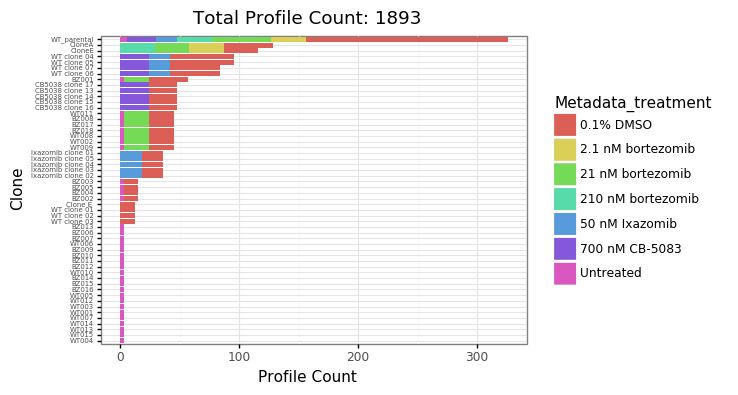

<ggplot: (-9223372036582152553)>

In [8]:
total_count = plot_ready_df.profile_count.sum()
total_label = "Total Profile Count: {}".format(total_count)

treatment_count_gg = (
    gg.ggplot(plot_ready_df, gg.aes(y="profile_count", x="Metadata_clone")) +
    gg.geom_bar(gg.aes(fill="Metadata_treatment"), position="stack", stat="identity") +
    gg.coord_flip() +
    gg.theme_bw() +
    gg.theme(axis_text_y=gg.element_text(size=5)) +
    gg.ylab("Profile Count") +
    gg.xlab("Clone") +
    gg.ggtitle(total_label)
)

output_figure = pathlib.Path("figures", "treatment_count.png")
treatment_count_gg.save(output_figure, height=4, width=5.5, dpi=400, verbose=False)

treatment_count_gg

In [9]:
# How many unique clones
len(sample_treatment_count_df.index.unique())

54

In [10]:
all_profile_counts = []
for key, value in batch_data.items():
    all_profile_counts.append(batch_data[key]["batch_count"])

profile_counts_df = pd.concat(all_profile_counts, axis="rows").reset_index(drop=True)
profile_counts_df

,Metadata_Plate,profile_count,batch
0,HCT116bortezomib,36,2019_02_15_Batch1_20X
1,HCT116bortezomib,36,2019_02_15_Batch1_40X
2,207106_exposure320,36,2019_03_20_Batch2
3,MutClones,57,2019_06_25_Batch3
4,WTClones,48,2019_06_25_Batch3
5,WTmut04hWed,60,2019_11_11_Batch4
6,WTmut04hTh,60,2019_11_11_Batch4
7,217755,60,2019_11_19_Batch5
8,217762,60,2019_11_20_Batch6
9,217760,60,2019_11_20_Batch6


In [11]:
all_treatment_counts = []
for key, value in batch_data.items():
    all_treatment_counts.append(batch_data[key]["treatment_count"])

treatment_counts_df = pd.concat(all_treatment_counts, axis="rows", sort=True).reset_index(drop=True)

treatment_counts_df.head()

,Metadata_Plate,Metadata_clone,Metadata_treatment,batch,profile_count
0,HCT116bortezomib,CloneA,0.1% DMSO,2019_02_15_Batch1_20X,3
1,HCT116bortezomib,CloneA,2.1 nM bortezomib,2019_02_15_Batch1_20X,3
2,HCT116bortezomib,CloneA,21 nM bortezomib,2019_02_15_Batch1_20X,3
3,HCT116bortezomib,CloneA,210 nM bortezomib,2019_02_15_Batch1_20X,3
4,HCT116bortezomib,CloneE,0.1% DMSO,2019_02_15_Batch1_20X,3


In [12]:
clone_counts_df = (
    treatment_counts_df
    .groupby(["Metadata_clone", "Metadata_treatment"])
    ["profile_count"]
    .sum()
    .reset_index()
    .sort_values(by=["Metadata_clone", "Metadata_treatment"])
)

output_file = pathlib.Path("tables/clone_counts_bortezomib.csv")
clone_counts_df.to_csv(output_file, sep=',', index=False)

clone_counts_df

,Metadata_clone,Metadata_treatment,profile_count
0,BZ001,0.1% DMSO,33
1,BZ001,21 nM bortezomib,21
2,BZ001,Untreated,3
3,BZ002,0.1% DMSO,12
4,BZ002,Untreated,3
5,BZ003,0.1% DMSO,12
6,BZ003,Untreated,3
7,BZ004,0.1% DMSO,12
8,BZ004,Untreated,3
9,BZ005,0.1% DMSO,12


## Visualize Counts

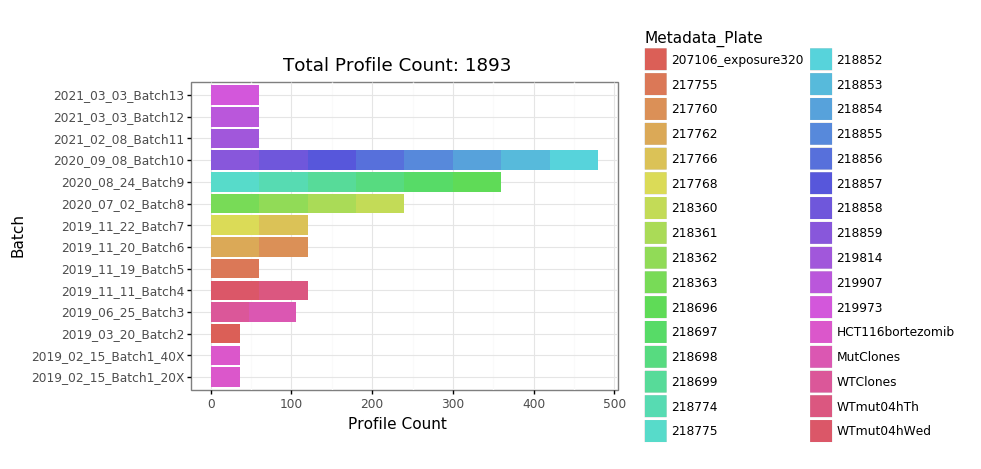

<ggplot: (298820016)>

In [13]:
total_count = profile_counts_df.profile_count.sum()
total_label = "Total Profile Count: {}".format(total_count)

profile_counts_df.Metadata_Plate = profile_counts_df.Metadata_Plate.astype(str)

batch_count_gg = (
    gg.ggplot(profile_counts_df, gg.aes(y="profile_count", x="batch")) +
    gg.geom_bar(gg.aes(fill="Metadata_Plate"), stat="identity") +
    gg.coord_flip() +
    gg.theme_bw() +
    gg.ylab("Profile Count") +
    gg.xlab("Batch") +
    gg.ggtitle(total_label)
)

output_figure = pathlib.Path("figures/batch_count.png")
batch_count_gg.save(output_figure, height=4, width=5.5, dpi=400, verbose=False)

batch_count_gg

## Output Metadata Counts for Each Batch

For quick description

In [14]:
suspect_batches = [
    "2019_06_25_Batch3", # Too confluent, not even DMSO control
    "2019_11_11_Batch4", # Too confluent
    "2019_11_19_Batch5", # Too confluent
]

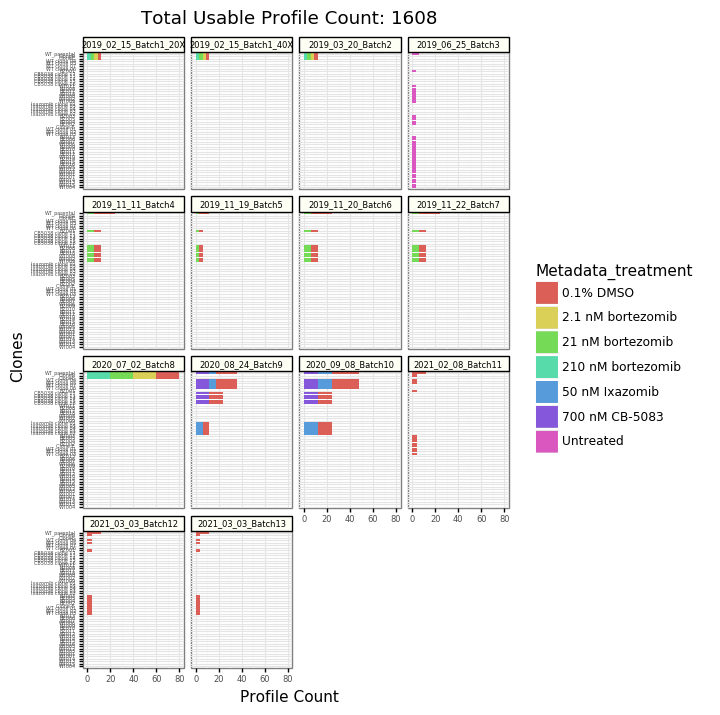

<ggplot: (300132907)>

In [15]:
non_suspect_counts = treatment_counts_df.loc[~treatment_counts_df.batch.isin(suspect_batches), :]
treatment_counts_df.Metadata_clone = pd.Categorical(
    treatment_counts_df.Metadata_clone,
    categories=clone_order
)

total_count = non_suspect_counts.profile_count.sum()
total_label = "Total Usable Profile Count: {}".format(total_count)

treatment_count_by_batch_gg = (
    gg.ggplot(treatment_counts_df, gg.aes(y="profile_count", x="Metadata_clone")) +
    gg.geom_bar(gg.aes(fill="Metadata_treatment"), position="stack", stat="identity") +
    gg.coord_flip() +
    gg.facet_wrap("~batch") +
    gg.theme_bw() +
    gg.theme(
        axis_text_y=gg.element_text(size=3.5),
        axis_text_x=gg.element_text(size=6),
        strip_text=gg.element_text(size=6, color="black"),
        strip_background=gg.element_rect(colour="black", fill="#fdfff4")
    ) +
    gg.ylab("Profile Count") +
    gg.xlab("Clones") +
    gg.ggtitle(total_label)
)

output_figure = pathlib.Path("figures/treatment_count_by_batch.png")
treatment_count_by_batch_gg.save(output_figure, height=8, width=5.5, dpi=400, verbose=False)

treatment_count_by_batch_gg

In [16]:
batch1_40x_df = treatment_counts_df.query("batch == '2019_02_15_Batch1_40X'").dropna(axis="columns")
batch1_40x_df

,Metadata_Plate,Metadata_clone,Metadata_treatment,batch,profile_count
12,HCT116bortezomib,CloneA,0.1% DMSO,2019_02_15_Batch1_40X,3
13,HCT116bortezomib,CloneA,2.1 nM bortezomib,2019_02_15_Batch1_40X,3
14,HCT116bortezomib,CloneA,21 nM bortezomib,2019_02_15_Batch1_40X,3
15,HCT116bortezomib,CloneA,210 nM bortezomib,2019_02_15_Batch1_40X,3
16,HCT116bortezomib,CloneE,0.1% DMSO,2019_02_15_Batch1_40X,3
17,HCT116bortezomib,CloneE,2.1 nM bortezomib,2019_02_15_Batch1_40X,3
18,HCT116bortezomib,CloneE,21 nM bortezomib,2019_02_15_Batch1_40X,3
19,HCT116bortezomib,CloneE,210 nM bortezomib,2019_02_15_Batch1_40X,3
20,HCT116bortezomib,WT_parental,0.1% DMSO,2019_02_15_Batch1_40X,3
21,HCT116bortezomib,WT_parental,2.1 nM bortezomib,2019_02_15_Batch1_40X,3


In [17]:
batch1_20x_df = treatment_counts_df.query("batch == '2019_02_15_Batch1_20X'").dropna(axis="columns")
batch1_20x_df

,Metadata_Plate,Metadata_clone,Metadata_treatment,batch,profile_count
0,HCT116bortezomib,CloneA,0.1% DMSO,2019_02_15_Batch1_20X,3
1,HCT116bortezomib,CloneA,2.1 nM bortezomib,2019_02_15_Batch1_20X,3
2,HCT116bortezomib,CloneA,21 nM bortezomib,2019_02_15_Batch1_20X,3
3,HCT116bortezomib,CloneA,210 nM bortezomib,2019_02_15_Batch1_20X,3
4,HCT116bortezomib,CloneE,0.1% DMSO,2019_02_15_Batch1_20X,3
5,HCT116bortezomib,CloneE,2.1 nM bortezomib,2019_02_15_Batch1_20X,3
6,HCT116bortezomib,CloneE,21 nM bortezomib,2019_02_15_Batch1_20X,3
7,HCT116bortezomib,CloneE,210 nM bortezomib,2019_02_15_Batch1_20X,3
8,HCT116bortezomib,WT_parental,0.1% DMSO,2019_02_15_Batch1_20X,3
9,HCT116bortezomib,WT_parental,2.1 nM bortezomib,2019_02_15_Batch1_20X,3


In [18]:
batch2_df = treatment_counts_df.query("batch == '2019_03_20_Batch2'").dropna(axis="columns")
batch2_df

,Metadata_Plate,Metadata_clone,Metadata_treatment,batch,profile_count
24,207106_exposure320,CloneA,0.1% DMSO,2019_03_20_Batch2,3
25,207106_exposure320,CloneA,2.1 nM bortezomib,2019_03_20_Batch2,3
26,207106_exposure320,CloneA,21 nM bortezomib,2019_03_20_Batch2,3
27,207106_exposure320,CloneA,210 nM bortezomib,2019_03_20_Batch2,3
28,207106_exposure320,CloneE,0.1% DMSO,2019_03_20_Batch2,3
29,207106_exposure320,CloneE,2.1 nM bortezomib,2019_03_20_Batch2,3
30,207106_exposure320,CloneE,21 nM bortezomib,2019_03_20_Batch2,3
31,207106_exposure320,CloneE,210 nM bortezomib,2019_03_20_Batch2,3
32,207106_exposure320,WT_parental,0.1% DMSO,2019_03_20_Batch2,3
33,207106_exposure320,WT_parental,2.1 nM bortezomib,2019_03_20_Batch2,3


In [19]:
batch3_df = treatment_counts_df.query("batch == '2019_06_25_Batch3'").dropna(axis="columns")
batch3_df

,Metadata_Plate,Metadata_clone,Metadata_treatment,batch,profile_count
36,MutClones,BZ001,Untreated,2019_06_25_Batch3,3
37,MutClones,BZ002,Untreated,2019_06_25_Batch3,3
38,MutClones,BZ003,Untreated,2019_06_25_Batch3,3
39,MutClones,BZ004,Untreated,2019_06_25_Batch3,3
40,MutClones,BZ005,Untreated,2019_06_25_Batch3,3
41,MutClones,BZ006,Untreated,2019_06_25_Batch3,3
42,MutClones,BZ007,Untreated,2019_06_25_Batch3,3
43,MutClones,BZ008,Untreated,2019_06_25_Batch3,3
44,MutClones,BZ009,Untreated,2019_06_25_Batch3,3
45,MutClones,BZ010,Untreated,2019_06_25_Batch3,3


In [20]:
batch4_df = treatment_counts_df.query("batch == '2019_11_11_Batch4'").dropna(axis="columns")
batch4_df

,Metadata_Plate,Metadata_clone,Metadata_treatment,batch,profile_count
71,WTmut04hTh,BZ001,0.1% DMSO,2019_11_11_Batch4,3
72,WTmut04hWed,BZ001,0.1% DMSO,2019_11_11_Batch4,3
73,WTmut04hTh,BZ001,21 nM bortezomib,2019_11_11_Batch4,3
74,WTmut04hWed,BZ001,21 nM bortezomib,2019_11_11_Batch4,3
75,WTmut04hTh,BZ008,0.1% DMSO,2019_11_11_Batch4,3
76,WTmut04hWed,BZ008,0.1% DMSO,2019_11_11_Batch4,3
77,WTmut04hTh,BZ008,21 nM bortezomib,2019_11_11_Batch4,3
78,WTmut04hWed,BZ008,21 nM bortezomib,2019_11_11_Batch4,3
79,WTmut04hTh,BZ017,0.1% DMSO,2019_11_11_Batch4,3
80,WTmut04hWed,BZ017,0.1% DMSO,2019_11_11_Batch4,3


In [21]:
batch5_df = treatment_counts_df.query("batch == '2019_11_19_Batch5'").dropna(axis="columns")
batch5_df

,Metadata_Plate,Metadata_clone,Metadata_treatment,batch,profile_count
107,217755,BZ001,0.1% DMSO,2019_11_19_Batch5,3
108,217755,BZ001,21 nM bortezomib,2019_11_19_Batch5,3
109,217755,BZ008,0.1% DMSO,2019_11_19_Batch5,3
110,217755,BZ008,21 nM bortezomib,2019_11_19_Batch5,3
111,217755,BZ017,0.1% DMSO,2019_11_19_Batch5,3
112,217755,BZ017,21 nM bortezomib,2019_11_19_Batch5,3
113,217755,BZ018,0.1% DMSO,2019_11_19_Batch5,3
114,217755,BZ018,21 nM bortezomib,2019_11_19_Batch5,3
115,217755,WT002,0.1% DMSO,2019_11_19_Batch5,3
116,217755,WT002,21 nM bortezomib,2019_11_19_Batch5,3


In [22]:
batch6_df = treatment_counts_df.query("batch == '2019_11_20_Batch6'").dropna(axis="columns")
batch6_df

,Metadata_Plate,Metadata_clone,Metadata_treatment,batch,profile_count
125,217760,BZ001,0.1% DMSO,2019_11_20_Batch6,3
126,217762,BZ001,0.1% DMSO,2019_11_20_Batch6,3
127,217760,BZ001,21 nM bortezomib,2019_11_20_Batch6,3
128,217762,BZ001,21 nM bortezomib,2019_11_20_Batch6,3
129,217760,BZ008,0.1% DMSO,2019_11_20_Batch6,3
130,217762,BZ008,0.1% DMSO,2019_11_20_Batch6,3
131,217760,BZ008,21 nM bortezomib,2019_11_20_Batch6,3
132,217762,BZ008,21 nM bortezomib,2019_11_20_Batch6,3
133,217760,BZ017,0.1% DMSO,2019_11_20_Batch6,3
134,217762,BZ017,0.1% DMSO,2019_11_20_Batch6,3


In [23]:
batch7_df = treatment_counts_df.query("batch == '2019_11_22_Batch7'").dropna(axis="columns")
batch7_df

,Metadata_Plate,Metadata_clone,Metadata_treatment,batch,profile_count
161,217766,BZ001,0.1% DMSO,2019_11_22_Batch7,3
162,217768,BZ001,0.1% DMSO,2019_11_22_Batch7,3
163,217766,BZ001,21 nM bortezomib,2019_11_22_Batch7,3
164,217768,BZ001,21 nM bortezomib,2019_11_22_Batch7,3
165,217766,BZ008,0.1% DMSO,2019_11_22_Batch7,3
166,217768,BZ008,0.1% DMSO,2019_11_22_Batch7,3
167,217766,BZ008,21 nM bortezomib,2019_11_22_Batch7,3
168,217768,BZ008,21 nM bortezomib,2019_11_22_Batch7,3
169,217766,BZ017,0.1% DMSO,2019_11_22_Batch7,3
170,217768,BZ017,0.1% DMSO,2019_11_22_Batch7,3


In [24]:
batch8_df = treatment_counts_df.query("batch == '2020_07_02_Batch8'").dropna(axis="columns")
batch8_df

,Metadata_Plate,Metadata_clone,Metadata_treatment,batch,profile_count
197,218360,CloneA,0.1% DMSO,2020_07_02_Batch8,5
198,218361,CloneA,0.1% DMSO,2020_07_02_Batch8,5
199,218362,CloneA,0.1% DMSO,2020_07_02_Batch8,5
200,218363,CloneA,0.1% DMSO,2020_07_02_Batch8,5
201,218360,CloneA,2.1 nM bortezomib,2020_07_02_Batch8,5
202,218361,CloneA,2.1 nM bortezomib,2020_07_02_Batch8,5
203,218362,CloneA,2.1 nM bortezomib,2020_07_02_Batch8,5
204,218363,CloneA,2.1 nM bortezomib,2020_07_02_Batch8,5
205,218360,CloneA,21 nM bortezomib,2020_07_02_Batch8,5
206,218361,CloneA,21 nM bortezomib,2020_07_02_Batch8,5


In [25]:
batch9_df = treatment_counts_df.query("batch == '2020_08_24_Batch9'").dropna(axis="columns")
batch9_df

,Metadata_Plate,Metadata_clone,Metadata_treatment,batch,profile_count
245,218696,CB5038 clone 13,0.1% DMSO,2020_08_24_Batch9,6
246,218774,CB5038 clone 13,0.1% DMSO,2020_08_24_Batch9,6
247,218697,CB5038 clone 13,700 nM CB-5083,2020_08_24_Batch9,6
248,218775,CB5038 clone 13,700 nM CB-5083,2020_08_24_Batch9,6
249,218696,CB5038 clone 14,0.1% DMSO,2020_08_24_Batch9,6
250,218774,CB5038 clone 14,0.1% DMSO,2020_08_24_Batch9,6
251,218697,CB5038 clone 14,700 nM CB-5083,2020_08_24_Batch9,6
252,218775,CB5038 clone 14,700 nM CB-5083,2020_08_24_Batch9,6
253,218696,CB5038 clone 15,0.1% DMSO,2020_08_24_Batch9,6
254,218774,CB5038 clone 15,0.1% DMSO,2020_08_24_Batch9,6


In [26]:
batch10_df = treatment_counts_df.query("batch == '2020_09_08_Batch10'").dropna(axis="columns")
batch10_df

,Metadata_Plate,Metadata_clone,Metadata_treatment,batch,profile_count
305,218852,CB5038 clone 13,0.1% DMSO,2020_09_08_Batch10,6
306,218856,CB5038 clone 13,0.1% DMSO,2020_09_08_Batch10,6
307,218853,CB5038 clone 13,700 nM CB-5083,2020_09_08_Batch10,6
308,218857,CB5038 clone 13,700 nM CB-5083,2020_09_08_Batch10,6
309,218852,CB5038 clone 14,0.1% DMSO,2020_09_08_Batch10,6
310,218856,CB5038 clone 14,0.1% DMSO,2020_09_08_Batch10,6
311,218853,CB5038 clone 14,700 nM CB-5083,2020_09_08_Batch10,6
312,218857,CB5038 clone 14,700 nM CB-5083,2020_09_08_Batch10,6
313,218852,CB5038 clone 15,0.1% DMSO,2020_09_08_Batch10,6
314,218856,CB5038 clone 15,0.1% DMSO,2020_09_08_Batch10,6


In [27]:
batch11_df = treatment_counts_df.query("batch == '2021_02_08_Batch11'").dropna(axis="columns")
batch11_df

,Metadata_Plate,Metadata_clone,Metadata_treatment,batch,profile_count
385,219814,BZ001,0.1% DMSO,2021_02_08_Batch11,4
386,219814,BZ002,0.1% DMSO,2021_02_08_Batch11,4
387,219814,BZ003,0.1% DMSO,2021_02_08_Batch11,4
388,219814,BZ004,0.1% DMSO,2021_02_08_Batch11,4
389,219814,BZ005,0.1% DMSO,2021_02_08_Batch11,4
390,219814,Clone E,0.1% DMSO,2021_02_08_Batch11,4
391,219814,CloneA,0.1% DMSO,2021_02_08_Batch11,4
392,219814,WT clone 01,0.1% DMSO,2021_02_08_Batch11,4
393,219814,WT clone 02,0.1% DMSO,2021_02_08_Batch11,4
394,219814,WT clone 03,0.1% DMSO,2021_02_08_Batch11,4


In [28]:
batch12_df = treatment_counts_df.query("batch == '2021_03_03_Batch12'").dropna(axis="columns")
batch12_df

,Metadata_Plate,Metadata_clone,Metadata_treatment,batch,profile_count
398,219907,BZ001,0.1% DMSO,2021_03_03_Batch12,4
399,219907,BZ002,0.1% DMSO,2021_03_03_Batch12,4
400,219907,BZ003,0.1% DMSO,2021_03_03_Batch12,4
401,219907,BZ004,0.1% DMSO,2021_03_03_Batch12,4
402,219907,BZ005,0.1% DMSO,2021_03_03_Batch12,4
403,219907,Clone E,0.1% DMSO,2021_03_03_Batch12,4
404,219907,CloneA,0.1% DMSO,2021_03_03_Batch12,4
405,219907,WT clone 01,0.1% DMSO,2021_03_03_Batch12,4
406,219907,WT clone 02,0.1% DMSO,2021_03_03_Batch12,4
407,219907,WT clone 03,0.1% DMSO,2021_03_03_Batch12,4


In [29]:
batch13_df = treatment_counts_df.query("batch == '2021_03_03_Batch13'").dropna(axis="columns")
batch13_df

,Metadata_Plate,Metadata_clone,Metadata_treatment,batch,profile_count
411,219973,BZ001,0.1% DMSO,2021_03_03_Batch13,4
412,219973,BZ002,0.1% DMSO,2021_03_03_Batch13,4
413,219973,BZ003,0.1% DMSO,2021_03_03_Batch13,4
414,219973,BZ004,0.1% DMSO,2021_03_03_Batch13,4
415,219973,BZ005,0.1% DMSO,2021_03_03_Batch13,4
416,219973,Clone E,0.1% DMSO,2021_03_03_Batch13,4
417,219973,CloneA,0.1% DMSO,2021_03_03_Batch13,4
418,219973,WT clone 01,0.1% DMSO,2021_03_03_Batch13,4
419,219973,WT clone 02,0.1% DMSO,2021_03_03_Batch13,4
420,219973,WT clone 03,0.1% DMSO,2021_03_03_Batch13,4
